#### <b>Download the Dataset</b>

* The dataset contains approximately 13,000 Korean "human face" images.
* In this dataset, all faces are cropped to a resolution of 128 X 128 pixels, although some of the original images have been high resolution.
* Each image filename indicates which family (household) number it belongs to.

In [ ]:
%%capture
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EbMhBPnmIb5MutZvGicPKggBWKm5hLs0iwKfGW7_TwQIKg?download=1 -O custom_korean_family_dataset_resolution_128.zip
!unzip custom_korean_family_dataset_resolution_128.zip -d ./custom_korean_family_dataset_resolution_128

#### <b>Load Libraries</b>

* Load various useful python libraries for the experiments.

In [67]:
import os
import time
import random
import glob
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms, models
import torchvision.transforms.functional as TF
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn import linear_model, model_selection

#### <b>Family Relationship Dataset</b>

1. It consists of a total of 900 households and approximately exact 13,068 individuals.
2. The last part of the filename, such as "a1", indicates the "age group".
  * This dataset consists of 8 age group classes.
  * The task is one of the 8-classes classification problem.
  * If we perform random guessing, the accuracy is approximately 12.5%.
3. The age classification problem is somewhat challenging, thus, we expect that our dataset will be helpful for evaluating the forgetting performance of a machine unlearning algorithm.
  * Our proposed setting has been configured in a way that is almost similar to the NeurIPS Kaggle Competition 2023 held on Kaggle.
4. We have utilized "Family Relationship Dataset" from AI Hub for constructing this dataset.
  * <b>Link</b>: https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=&topMenu=&aihubDataSe=realm&dataSetSn=528

#### <b>Load Datasets</b>

* The following three datasets do not overlap at the household level.
  * Thus, our setting ensures any individual "subjects" are overlapped across the following three sub-dataset.
  * In other wrods, we set any person (subject) to do not simultaneously belonging to the $\mathcal{D}_{train}$, $\mathcal{D}_{test}$ and $\mathcal{D}_{unseen}$.
* <b>Training dataset $\mathcal{D}_{train}$</b>: (F0001 ~ F0299) folders have 10,025 images.
* <b>Test dataset $\mathcal{D}_{test}$</b>: (F0801 ~ F0850) folders have 1,539 images.
* <b>Unseen dataset $\mathcal{D}_{unseen}$</b>: (F0851 ~ F0900) folders have 1,504 images.

In [2]:
"""
> [Function] Parse the metadata.
* image_age_list[0] = ["F0001_AGE_D_18_a1.jpg"] = "a"
* image_age_list[1] = ["F0001_AGE_D_18_a2.jpg"] = "a"
* image_age_list[2] = ["F0001_AGE_D_18_a3.jpg"] = "a"
* image_age_list[3] = ["F0001_AGE_D_18_a4.jpg"] = "a"
* image_age_list[4] = ["F0001_AGE_D_18_b1.jpg"] = "b"
...
"""
def parsing(meta_data):
    image_age_list = []
    # iterate all rows in the metadata file
    for idx, row in meta_data.iterrows():
        image_path = row['image_path']
        age_class = row['age_class']
        image_age_list.append([image_path, age_class])
    return image_age_list

In [3]:
class Dataset(Dataset):
    def __init__(self, meta_data, image_directory, transform=None, forget=False, retain=False):
        self.meta_data = meta_data
        self.image_directory = image_directory
        self.transform = transform

        # Process the metadata.
        image_age_list = parsing(meta_data)

        self.image_age_list = image_age_list
        self.age_class_to_label = {
            "a": 0, "b": 1, "c": 2, "d": 3, "e": 4, "f": 5, "g": 6, "h": 7
        }

        # After training the original model, we will do "machine unlearning".
        # The machine unlearning requires two datasets, ① forget dataset and ② retain dataset.
        # In this experiment, we set the first 1,500 images to be forgotten and the rest images to be retained.
        if forget:
            self.image_age_list = self.image_age_list[:1500]
        if retain:
            self.image_age_list = self.image_age_list[1500:]

    def __len__(self):
        return len(self.image_age_list)

    def __getitem__(self, idx):
        image_path, age_class = self.image_age_list[idx]
        img = Image.open(os.path.join(self.image_directory, image_path))
        label = self.age_class_to_label[age_class]

        if self.transform:
            img = self.transform(img)

        return img, label

In [4]:
label_to_age = {
    0: "0-6 years old",
    1: "7-12 years old",
    2: "13-19 years old",
    3: "20-30 years old",
    4: "31-45 years old",
    5: "46-55 years old",
    6: "56-66 years old",
    7: "67-80 years old"
}

train_meta_data_path = "./custom_korean_family_dataset_resolution_128/custom_train_dataset.csv"
train_meta_data = pd.read_csv(train_meta_data_path)
train_image_directory = "./custom_korean_family_dataset_resolution_128/train_images"

test_meta_data_path = "./custom_korean_family_dataset_resolution_128/custom_val_dataset.csv"
test_meta_data = pd.read_csv(test_meta_data_path)
test_image_directory = "./custom_korean_family_dataset_resolution_128/val_images"

unseen_meta_data_path = "./custom_korean_family_dataset_resolution_128/custom_test_dataset.csv"
unseen_meta_data = pd.read_csv(unseen_meta_data_path)
unseen_image_directory = "./custom_korean_family_dataset_resolution_128/test_images"

train_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor()
])

unseen_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor()
])

train_dataset = Dataset(train_meta_data, train_image_directory, train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = Dataset(test_meta_data, test_image_directory, test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

unseen_dataset = Dataset(unseen_meta_data, unseen_image_directory, unseen_transform)
unseen_dataloader = DataLoader(unseen_dataset, batch_size=64, shuffle=False)

In [5]:
forget_dataset_train = Dataset(train_meta_data, train_image_directory, train_transform, forget=True)
forget_dataloader_train = DataLoader(forget_dataset_train, batch_size=64, shuffle=True)

retain_dataset_train = Dataset(train_meta_data, train_image_directory, train_transform, retain=True)
retain_dataloader_train = DataLoader(retain_dataset_train, batch_size=64, shuffle=True)

forget_dataset_test = Dataset(train_meta_data, train_image_directory, test_transform, forget=True)
forget_dataloader_test = DataLoader(forget_dataset_test, batch_size=64, shuffle=False)

retain_dataset_test = Dataset(train_meta_data, train_image_directory, test_transform, retain=True)
retain_dataloader_test = DataLoader(retain_dataset_test, batch_size=64, shuffle=False)

In [6]:
print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))
print('Forget dataset size:', len(forget_dataset_train))
print('Retain dataset size:', len(retain_dataset_train))
print('Unseen dataset size:', len(unseen_dataset))

Train dataset size: 10025
Test dataset size: 1539
Forget dataset size: 1500
Retain dataset size: 8525
Unseen dataset size: 1504


In [7]:
# Checking for duplicates across datasets
train_image_paths = [x[0] for x in train_dataset.image_age_list]
test_image_paths = [x[0] for x in test_dataset.image_age_list]
forget_image_paths = [x[0] for x in forget_dataset_train.image_age_list]
retain_image_paths = [x[0] for x in retain_dataset_train.image_age_list]
unseen_image_paths = [x[0] for x in unseen_dataset.image_age_list]

train_test_overlap = len(set(train_image_paths) & set(test_image_paths))
train_forget_overlap = len(set(train_image_paths) & set(forget_image_paths))
train_retain_overlap = len(set(train_image_paths) & set(retain_image_paths))
train_unseen_overlap = len(set(train_image_paths) & set(unseen_image_paths))
test_forget_overlap = len(set(test_image_paths) & set(forget_image_paths))
test_retain_overlap = len(set(test_image_paths) & set(retain_image_paths))
test_unseen_overlap = len(set(test_image_paths) & set(unseen_image_paths))
forget_retain_overlap = len(set(forget_image_paths) & set(retain_image_paths))
forget_unseen_overlap = len(set(forget_image_paths) & set(unseen_image_paths))
retain_unseen_overlap = len(set(retain_image_paths) & set(unseen_image_paths))

overlap_dict = {
    'train_test': train_test_overlap,
    'train_forget': train_forget_overlap,
    'train_retain': train_retain_overlap,
    'train_unseen': train_unseen_overlap,
    'test_forget': test_forget_overlap,
    'test_retain': test_retain_overlap,
    'test_unseen': test_unseen_overlap,
    'forget_retain': forget_retain_overlap,
    'forget_unseen': forget_unseen_overlap,
    'retain_unseen': retain_unseen_overlap
}
overlap_dict

{'train_test': 0,
 'train_forget': 1500,
 'train_retain': 8525,
 'train_unseen': 0,
 'test_forget': 0,
 'test_retain': 0,
 'test_unseen': 0,
 'forget_retain': 0,
 'forget_unseen': 0,
 'retain_unseen': 0}

#### <b>Dataset Visualization</b>

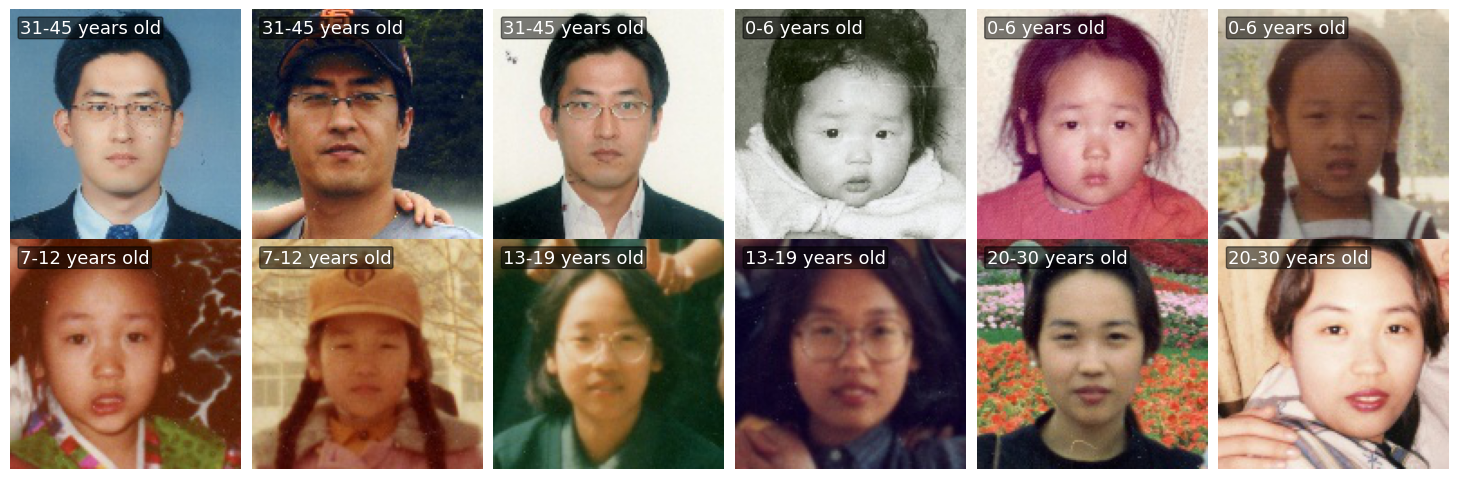

In [8]:
def show_images(images, labels, nrow=6, save_path=None):
    n_images = len(images)
    nrows = n_images // nrow + (n_images % nrow > 0)
    fig, axs = plt.subplots(nrows, nrow, figsize=(14.5, 2.3 * nrows), frameon=False)
    axs = axs.flatten() if n_images > 1 else [axs]

    for idx, (img, label) in enumerate(zip(images, labels)):
        ax = axs[idx]
        img_np = img.numpy().transpose((1, 2, 0))
        ax.imshow(img_np)
        ax.axis('off')

        ax.text(5, 5, label, color='white', fontsize=13,  ha='left', va='top',
                bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.1'))
    plt.tight_layout(pad=0)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    plt.show()

iterator = iter(test_dataloader)
imgs, labels = next(iterator)
label_strs = [label_to_age[label.item()] for label in labels[7:19]]

show_images(imgs[7:19], label_strs, nrow=6)

#### <b>Define the necessary functions</b>

In [8]:
def compute_losses(net, loader):
    criterion = nn.CrossEntropyLoss(reduction="none")
    all_losses = []

    for inputs, y in loader:
        targets = y
        inputs, targets = inputs.cuda(), targets.cuda()

        logits = net(inputs)

        losses = criterion(logits, targets).cpu().detach().numpy()
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)

def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy"
    )

def cal_mia(model):
    set_seed()

    forget_losses = compute_losses(model, forget_dataloader_test)
    unseen_losses = compute_losses(model, unseen_dataloader)

    np.random.shuffle(forget_losses)
    forget_losses = forget_losses[: len(unseen_losses)]

    samples_mia = np.concatenate((unseen_losses, forget_losses)).reshape((-1, 1))
    labels_mia = [0] * len(unseen_losses) + [1] * len(forget_losses)

    mia_scores = simple_mia(samples_mia, labels_mia)
    forgetting_score = abs(0.5 - mia_scores.mean())

    return {'MIA': mia_scores.mean(), 'Forgeting Score': forgetting_score}

In [9]:
import numpy as np
from scipy.stats import gaussian_kde
from scipy.spatial.distance import jensenshannon

def calculate_jsd_between_losses(losses1, losses2):
    set_seed()
    # Generate a range of values that covers both loss arrays
    x_range = np.linspace(min(min(losses1), min(losses2)), max(max(losses1), max(losses2)), num=1000)

    # Calculate the KDE for each set of losses over the defined range
    kde1 = gaussian_kde(losses1)(x_range)
    kde2 = gaussian_kde(losses2)(x_range)

    # Normalize the KDEs to form valid probability distributions
    kde1 /= np.trapz(kde1, x_range)
    kde2 /= np.trapz(kde2, x_range)

    # Calculate JSD using the probability distributions
    jsd_value = jensenshannon(kde1, kde2)

    return jsd_value

In [10]:
@torch.no_grad()
def evaluation(model, data_loader):
    start_time = time.time()
    print(f'[Test]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0
    running_top2_corrects = 0
    log_step = 20

    for i, batch in enumerate(data_loader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Top-2 accuracy.
            _, top2_preds = outputs.topk(2, dim=1)  # Get the top 2 class indices.
            top2_correct = top2_preds.eq(labels.view(-1, 1).expand_as(top2_preds))
            running_top2_corrects += top2_correct.any(dim=1).sum().item()

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data).item()

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running test loss: {running_loss / total}, running test accuracy: {running_corrects / total}, running top-2 accuracy: {running_top2_corrects / total}')

    print(f'test loss: {running_loss / total}, accuracy: {running_corrects / total}, top-2 accuracy: {running_top2_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return {'Loss': running_loss / total, 'Acc': running_corrects / total, 'Top-2 Acc': running_top2_corrects / total}

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

In [22]:
import seaborn as sns
def plot_kde_losses(losses1, losses2, data1="Forget", data2="Unseen", model_name="Model", figsize=(9, 5)):
    sns.set(style="whitegrid", rc={'axes.linewidth': 2, 'grid.linewidth': 0.5})

    plt.figure(figsize=figsize)

    # Plot the KDE for each set of losses
    sns.kdeplot(losses1, fill=True, color="#0B486B", label=f'{data1} Dataset Losses', alpha=0.4, linewidth=2.0)
    sns.kdeplot(losses2, fill=True, color="#D32F2F", label=f'{data2} Dataset Losses', alpha=0.4,linewidth=2.0)

    # Simplify the legend to show only one label per group
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), fontsize=15)

    title = f'Loss Distribution between {data1} and {data2} Datasets in {model_name} Model'
    plt.title(title, fontsize=14)
    plt.xlabel('Loss Value', fontsize=15)
    plt.ylabel('Density', fontsize=15)

    # Save the figure
#     plt.savefig(f"{model_name}_{data1}_{data2}_Losses_Distribution.png", dpi=300, bbox_inches='tight')
#     plt.savefig(f"{model_name}_{data1}_{data2}_Losses_Distribution.pdf", dpi=300, bbox_inches='tight')

    plt.show()

In [12]:
# ResNet18
def load_model(num_classes, model_path=None):
    model =  models.resnet18(pretrained=False)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    moodel = model.cuda()
    if model_path:
        model.load_state_dict(torch.load(model_path))
    return model

In [13]:
def train(model, dataloader):
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Training]')
    model.train()
    total = 0
    running_loss = 0.0
    running_corrects = 0
    log_step = 30

    for i, batch in enumerate(dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        outputs = model(imgs)
        optimizer.zero_grad()
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if i % log_step == log_step - 1:
            print(f'[Batch: {i + 1}] running train loss: {running_loss / total}, running train accuracy: {running_corrects / total}')

    print(f'train loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()


def test(model, dataloader):
    start_time = time.time()
    print(f'[Test]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0
    log_step = 30

    for i, batch in enumerate(dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running test loss: {running_loss / total}, running test accuracy: {running_corrects / total}')

    print(f'test loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

#### <b>Load the Pre-trained Original Model</b>

* We can easily download the pre-trained original model, rather than training the original model from scratch.
* <b>Download Link</b>: https://drive.google.com/file/d/1RgNsAZWH37MTWsxUdieGQFSVlweC1LsM/view?usp=drive_link

In [30]:
!gdown https://drive.google.com/uc?id=1RgNsAZWH37MTWsxUdieGQFSVlweC1LsM -O pre_trained_last_checkpoint_epoch_30.pth

Downloading...
From (uriginal): https://drive.google.com/uc?id=1pQvc30KVSj--RwB8ekznoNDsIWF8b1_v
From (redirected): https://drive.google.com/uc?id=1pQvc30KVSj--RwB8ekznoNDsIWF8b1_v&confirm=t&uuid=a379ae7a-0edd-438c-a357-8f5c77adce2d
To: /home/dasol/02_FM/ResNet_multi_label_64/lala.pth
100%|██████████████████████████████████████| 44.8M/44.8M [00:01<00:00, 41.2MB/s]


<b>Evaluating Performance of Original Model </b>

In [31]:
model_path = 'pre_trained_last_checkpoint_epoch_30.pth'
model = load_model(8, model_path)
criterion = nn.CrossEntropyLoss()

test_acc = evaluation(model, test_dataloader)
unseen_acc = evaluation(model, unseen_dataloader)
mia = cal_mia(model.cuda())
final_score = (test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2
model_forget_losses = compute_losses(model, forget_dataloader_test)
model_unseen_losses = compute_losses(model, unseen_dataloader)
jsd = calculate_jsd_between_losses(model_forget_losses, model_unseen_losses)
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print()
print(f'Final Score: {final_score}')
print(f'JSD: {jsd}')

[Test]
[Batch: 1] running test loss: 0.023215658962726593, running test accuracy: 0.65625, running top-2 accuracy: 0.9375
[Batch: 20] running test loss: 0.024261729186400773, running test accuracy: 0.60390625, running top-2 accuracy: 0.8875
test loss: 0.02659713335049625, accuracy: 0.5971410006497726, top-2 accuracy: 0.8856400259909032
elapsed time: 1.1959083080291748
[Test]
[Batch: 1] running test loss: 0.019177664071321487, running test accuracy: 0.640625, running top-2 accuracy: 0.953125
[Batch: 20] running test loss: 0.020300325565040113, running test accuracy: 0.65390625, running top-2 accuracy: 0.903125
test loss: 0.021293988094684926, accuracy: 0.6549202127659575, top-2 accuracy: 0.9002659574468085
elapsed time: 1.1514735221862793
Test Acc: {'Loss': 0.02659713335049625, 'Acc': 0.5971410006497726, 'Top-2 Acc': 0.8856400259909032}
Unseen Acc: {'Loss': 0.021293988094684926, 'Acc': 0.6549202127659575, 'Top-2 Acc': 0.9002659574468085}
MIA: {'MIA': 0.7139534883720932, 'Forgeting Score

### <b>Machine Unlearning Experiments</b>

#### <b>Fine-Tuning</b>
* A method where the original model undergoes further training solely on the retain dataset.
* This approach aims to reinforce the model's knowledge of the retain dataset, potentially leading to the forgetting of the previously learned forget dataset.

In [19]:
set_seed()
original_save_path = 'pre_trained_last_checkpoint_epoch_30.pth'
finetune_model = load_model(8, original_save_path)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(finetune_model.parameters(), lr=0.001)

num_epochs = 2
for epoch in range(num_epochs):
    running_loss = 0.0
    log_step = 20
    for batch_idx, (x_retain, y_retain) in enumerate(retain_dataloader_train):
        y_retain = y_retain.cuda()
        outputs_retain = finetune_model(x_retain.cuda())
        classification_loss = criterion(outputs_retain, y_retain)

        optimizer.zero_grad()
        classification_loss.backward()
        optimizer.step()
        running_loss += classification_loss.item() * x_retain.size(0)
        if batch_idx % log_step == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(retain_dataloader_train)}] - Batch Loss: {classification_loss.item():.4f}")

Epoch [1/2], Batch [1/134] - Batch Loss: 0.0759
Epoch [1/2], Batch [21/134] - Batch Loss: 0.1563
Epoch [1/2], Batch [41/134] - Batch Loss: 0.0630
Epoch [1/2], Batch [61/134] - Batch Loss: 0.1646
Epoch [1/2], Batch [81/134] - Batch Loss: 0.0960
Epoch [1/2], Batch [101/134] - Batch Loss: 0.1002
Epoch [1/2], Batch [121/134] - Batch Loss: 0.1023
Epoch [2/2], Batch [1/134] - Batch Loss: 0.0841
Epoch [2/2], Batch [21/134] - Batch Loss: 0.0335
Epoch [2/2], Batch [41/134] - Batch Loss: 0.0932
Epoch [2/2], Batch [61/134] - Batch Loss: 0.1545
Epoch [2/2], Batch [81/134] - Batch Loss: 0.0744
Epoch [2/2], Batch [101/134] - Batch Loss: 0.1677
Epoch [2/2], Batch [121/134] - Batch Loss: 0.0316


In [20]:
# Performance
test_acc = evaluation(finetune_model, test_dataloader)
unseen_acc = evaluation(finetune_model, unseen_dataloader)
mia = cal_mia(finetune_model.cuda())
final_score = (test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2
finetune_forget_losses = compute_losses(finetune_model, forget_dataloader_test)
finetune_unseen_losses = compute_losses(finetune_model, unseen_dataloader)
jsd = calculate_jsd_between_losses(finetune_forget_losses, finetune_unseen_losses)
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'JSD: {jsd}')
print()
print(f'Final Score: {final_score}')

[Test]
[Batch: 1] running test loss: 0.023671573027968407, running test accuracy: 0.640625, running top-2 accuracy: 0.9375
[Batch: 20] running test loss: 0.02484848494641483, running test accuracy: 0.59609375, running top-2 accuracy: 0.88671875
test loss: 0.02713943344962682, accuracy: 0.5893437296946069, top-2 accuracy: 0.8843404808317089
elapsed time: 1.33168625831604
[Test]
[Batch: 1] running test loss: 0.019826218485832214, running test accuracy: 0.625, running top-2 accuracy: 0.953125
[Batch: 20] running test loss: 0.0207532349973917, running test accuracy: 0.65703125, running top-2 accuracy: 0.8984375
test loss: 0.021703373125575957, accuracy: 0.6582446808510638, top-2 accuracy: 0.8969414893617021
elapsed time: 1.2110064029693604
Test Acc: {'Loss': 0.02713943344962682, 'Acc': 0.5893437296946069, 'Top-2 Acc': 0.8843404808317089}
Unseen Acc: {'Loss': 0.021703373125575957, 'Acc': 0.6582446808510638, 'Top-2 Acc': 0.8969414893617021}
MIA: {'MIA': 0.7093023255813954, 'Forgeting Score':

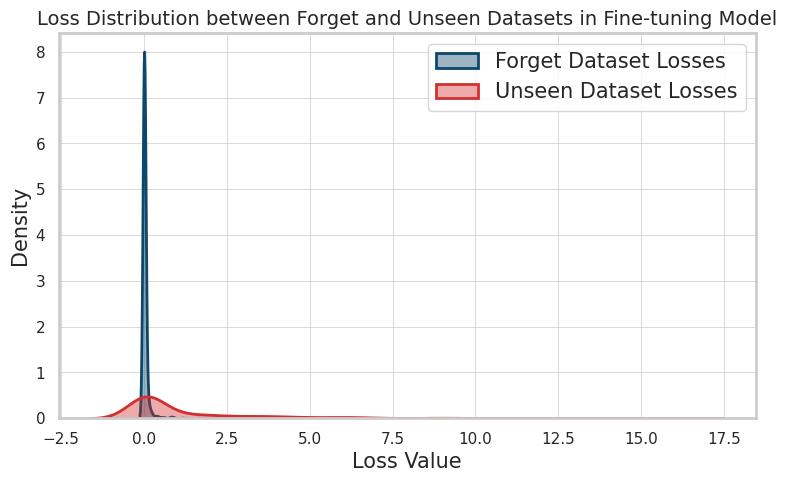

In [23]:
# visualize loss distribution
plot_kde_losses(finetune_forget_losses, finetune_unseen_losses, data1="Forget", data2="Unseen", model_name="Fine-tuning")

#### <b>CF-k (Class-wise Forgetting)</b>
* A strategy that fine-tunes specific layers to make the model forget target data while retaining class structures.

In [25]:
set_seed()
original_save_path = 'pre_trained_last_checkpoint_epoch_30.pth'
cf3_model = load_model(8, original_save_path)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, cf3_model.parameters()), lr=0.001)

# Freeze all the parameters
for param in cf3_model.parameters():
    param.requires_grad = False

# Unfreeze last 3 layers
unfreeze_blocks =  ['layer3', 'layer4', 'avgpool', 'fc'] 
for name, param in cf3_model.named_parameters():
    if any(block in name for block in unfreeze_blocks):
        print(f'unfreeze: {name}')
        param.requires_grad = True

num_epochs = 2
for epoch in range(num_epochs):
    
    running_loss = 0.0
    log_step = 20
    for batch_idx, (x_retain, y_retain) in enumerate(retain_dataloader_train):
        y_retain = y_retain.cuda()
        outputs_retain = cf3_model(x_retain.cuda())
        classification_loss = criterion(outputs_retain, y_retain)

        optimizer.zero_grad()
        classification_loss.backward()
        optimizer.step()

        running_loss += classification_loss.item() * x_retain.size(0)
        
        if batch_idx % log_step == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(retain_dataloader_train)}] - Batch Loss: {classification_loss.item():.4f}")

unfreeze: layer3.0.conv1.weight
unfreeze: layer3.0.bn1.weight
unfreeze: layer3.0.bn1.bias
unfreeze: layer3.0.conv2.weight
unfreeze: layer3.0.bn2.weight
unfreeze: layer3.0.bn2.bias
unfreeze: layer3.0.downsample.0.weight
unfreeze: layer3.0.downsample.1.weight
unfreeze: layer3.0.downsample.1.bias
unfreeze: layer3.1.conv1.weight
unfreeze: layer3.1.bn1.weight
unfreeze: layer3.1.bn1.bias
unfreeze: layer3.1.conv2.weight
unfreeze: layer3.1.bn2.weight
unfreeze: layer3.1.bn2.bias
unfreeze: layer4.0.conv1.weight
unfreeze: layer4.0.bn1.weight
unfreeze: layer4.0.bn1.bias
unfreeze: layer4.0.conv2.weight
unfreeze: layer4.0.bn2.weight
unfreeze: layer4.0.bn2.bias
unfreeze: layer4.0.downsample.0.weight
unfreeze: layer4.0.downsample.1.weight
unfreeze: layer4.0.downsample.1.bias
unfreeze: layer4.1.conv1.weight
unfreeze: layer4.1.bn1.weight
unfreeze: layer4.1.bn1.bias
unfreeze: layer4.1.conv2.weight
unfreeze: layer4.1.bn2.weight
unfreeze: layer4.1.bn2.bias
unfreeze: fc.weight
unfreeze: fc.bias
Epoch [1/2],

In [26]:
test_acc = evaluation(cf3_model, test_dataloader)
unseen_acc = evaluation(cf3_model, unseen_dataloader)
mia = cal_mia(cf3_model.cuda())
final_score = (test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2
cf3_forget_losses = compute_losses(cf3_model, forget_dataloader_test)
cf3_unseen_losses = compute_losses(cf3_model, unseen_dataloader)
jsd = calculate_jsd_between_losses(cf3_forget_losses, cf3_unseen_losses)
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'JSD: {jsd}')
print()
print(f'Final Score: {final_score}')

[Test]
[Batch: 1] running test loss: 0.02377188205718994, running test accuracy: 0.640625, running top-2 accuracy: 0.9375
[Batch: 20] running test loss: 0.024878057558089493, running test accuracy: 0.59609375, running top-2 accuracy: 0.88515625
test loss: 0.02714845543948763, accuracy: 0.5893437296946069, top-2 accuracy: 0.8830409356725146
elapsed time: 1.2279002666473389
[Test]
[Batch: 1] running test loss: 0.019754154607653618, running test accuracy: 0.625, running top-2 accuracy: 0.953125
[Batch: 20] running test loss: 0.020734094409272076, running test accuracy: 0.65703125, running top-2 accuracy: 0.8953125
test loss: 0.021707897926581666, accuracy: 0.6582446808510638, top-2 accuracy: 0.8936170212765957
elapsed time: 1.1863923072814941
Test Acc: {'Loss': 0.02714845543948763, 'Acc': 0.5893437296946069, 'Top-2 Acc': 0.8830409356725146}
Unseen Acc: {'Loss': 0.021707897926581666, 'Acc': 0.6582446808510638, 'Top-2 Acc': 0.8936170212765957}
MIA: {'MIA': 0.7109634551495017, 'Forgeting Sco

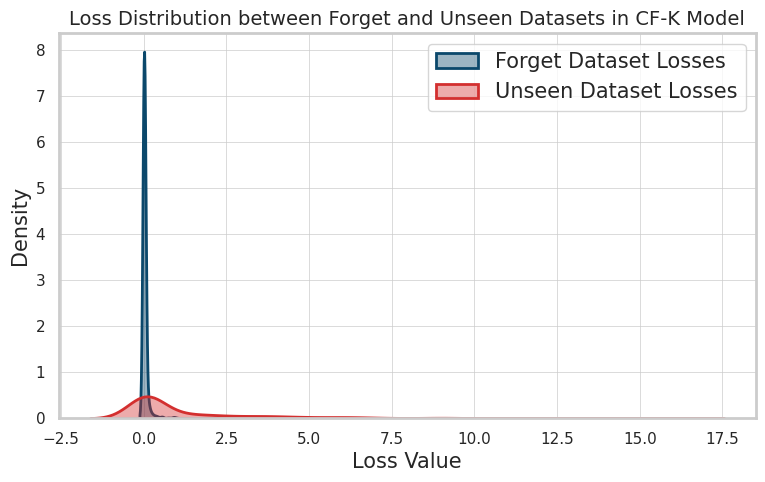

In [27]:
# visualize loss distribution
plot_kde_losses(cf3_forget_losses, cf3_unseen_losses, data1="Forget", data2="Unseen", model_name="CF-K")

#### <b>Negative Gradient Ascent</b>
* A strategy that induces the model to 'forget' particular data by deliberately maximizing the error on the forget dataset.

In [28]:
set_seed()
riginal_save_path = 'pre_trained_last_checkpoint_epoch_30.pth'
neg_model = load_model(8, original_save_path)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(neg_model.parameters(), lr=0.001)

num_epochs = 2
dataloader_iterator = iter(forget_dataloader_train)
for epoch in range(num_epochs):
    running_loss = 0
    log_step = 20
    for batch_idx, (x_retain, y_retain) in enumerate(retain_dataloader_train):
        y_retain = y_retain.cuda()

        try:
            (x_forget, y_forget) = next(dataloader_iterator)
        except StopIteration:
            dataloader_iterator = iter(forget_dataloader_train)
            (x_forget, y_forget) = next(dataloader_iterator)

        if x_forget.size(0) != x_retain.size(0):
            continue

        outputs_forget = neg_model(x_forget.cuda())
        loss_ascent_forget = -criterion(outputs_forget, y_forget.cuda())

        optimizer.zero_grad()
        loss_ascent_forget.backward()
        optimizer.step()
        running_loss += loss_ascent_forget.item() * x_retain.size(0)

        if batch_idx % log_step == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(retain_dataloader_train)}] - Batch Loss: {classification_loss.item():.4f}")

Epoch [1/2], Batch [1/134] - Batch Loss: 0.2365
Epoch [1/2], Batch [21/134] - Batch Loss: 0.2365
Epoch [1/2], Batch [41/134] - Batch Loss: 0.2365
Epoch [1/2], Batch [61/134] - Batch Loss: 0.2365
Epoch [1/2], Batch [81/134] - Batch Loss: 0.2365
Epoch [1/2], Batch [101/134] - Batch Loss: 0.2365
Epoch [1/2], Batch [121/134] - Batch Loss: 0.2365
Epoch [2/2], Batch [1/134] - Batch Loss: 0.2365
Epoch [2/2], Batch [21/134] - Batch Loss: 0.2365
Epoch [2/2], Batch [41/134] - Batch Loss: 0.2365
Epoch [2/2], Batch [61/134] - Batch Loss: 0.2365
Epoch [2/2], Batch [81/134] - Batch Loss: 0.2365
Epoch [2/2], Batch [101/134] - Batch Loss: 0.2365
Epoch [2/2], Batch [121/134] - Batch Loss: 0.2365


In [29]:
test_acc = evaluation(neg_model, test_dataloader)
unseen_acc = evaluation(neg_model, unseen_dataloader)
mia = cal_mia(neg_model.cuda())
final_score = (test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2
neg_forget_losses = compute_losses(neg_model, forget_dataloader_test)
neg_unseen_losses = compute_losses(neg_model, unseen_dataloader)
jsd = calculate_jsd_between_losses(neg_forget_losses, neg_unseen_losses)
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'JSD: {jsd}')
print()
print(f'Final Score: {final_score}')

[Test]
[Batch: 1] running test loss: 0.17302627861499786, running test accuracy: 0.484375, running top-2 accuracy: 0.65625
[Batch: 20] running test loss: 0.22551690340042113, running test accuracy: 0.38828125, running top-2 accuracy: 0.58203125
test loss: 0.2437475723752424, accuracy: 0.39116309291747886, top-2 accuracy: 0.5795971410006497
elapsed time: 1.2246406078338623
[Test]
[Batch: 1] running test loss: 0.15031275153160095, running test accuracy: 0.453125, running top-2 accuracy: 0.734375
[Batch: 20] running test loss: 0.20273976549506187, running test accuracy: 0.425, running top-2 accuracy: 0.6171875
test loss: 0.21029759531325481, accuracy: 0.43617021276595747, top-2 accuracy: 0.6196808510638298
elapsed time: 1.219351053237915
Test Acc: {'Loss': 0.2437475723752424, 'Acc': 0.39116309291747886, 'Top-2 Acc': 0.5795971410006497}
Unseen Acc: {'Loss': 0.21029759531325481, 'Acc': 0.43617021276595747, 'Top-2 Acc': 0.6196808510638298}
MIA: {'MIA': 0.546843853820598, 'Forgeting Score': 0

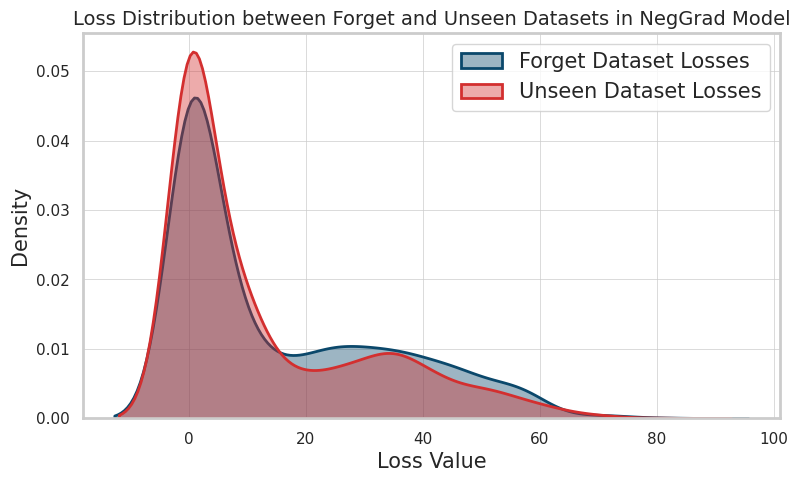

In [30]:
# visualize loss distribution
plot_kde_losses(neg_forget_losses, neg_unseen_losses, data1="Forget", data2="Unseen", model_name="NegGrad")

#### <b>UNSIR</b>
* UNSIR, initially developed for class-level unlearning, has been modified to enhance noise maximization, specifically targeting the model's loss in less relevant classes.
* <b>Impair phase (Stage 1)</b>: Update noise to increase the distance between the model and the forget dataset. Then, the updated noise is then integrated into the training dataset to enhance the model's ability to forget the specific dataset.
* <b>Repair phase (Stage 2)</b>: Repair the impaired model using the retain dataset.

<b> Stage1: Impair</b>

In [31]:
class Noise(nn.Module):
    def __init__(self, batch_size, *dim):
        super().__init__()
        self.noise = nn.Parameter(torch.randn(batch_size, *dim), requires_grad=True)

    def forward(self):
        return self.noise

In [34]:
set_seed()

original_save_path = 'pre_trained_last_checkpoint_epoch_30.pth'
unsir_model = load_model(8, original_save_path)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(unsir_model.parameters(), lr=0.001)

num_epochs = 2
for epoch in range(num_epochs):
    running_loss = 0
    log_step = 20
    for batch_idx, ((x_retain, y_retain), (x_forget, y_forget)) in enumerate(zip(retain_dataloader_train, forget_dataloader_train)):
        y_retain = y_retain.cuda()
        batch_size_forget = y_forget.size(0)

        if x_retain.size(0) != x_forget.size(0):
            continue

        # Initialize the noise.
        noise_dim = x_retain.size(1), x_retain.size(2), x_retain.size(3)
        noise = Noise(batch_size_forget, *noise_dim).cuda()
        noise_optimizer = torch.optim.Adam(noise.parameters(), lr=0.01)
        noise_tensor = noise()[:batch_size_forget]

        # Update the noise for increasing the loss value.
        for _ in range(5):
            outputs = unsir_model(noise_tensor)
            with torch.no_grad():
                target_logits = unsir_model(x_forget.cuda())
            # Maximize the similarity between noise data and forget features.
            loss_noise = -F.mse_loss(outputs, target_logits)

            # Backpropagate to update the noise.
            noise_optimizer.zero_grad()
            loss_noise.backward(retain_graph=True)
            noise_optimizer.step()

        # Train the model with noise and retain image
        noise_tensor = torch.clamp(noise_tensor, 0, 1).detach().cuda()
        outputs = unsir_model(noise_tensor.cuda())
        loss_1 = criterion(outputs, y_retain)

        outputs = unsir_model(x_retain.cuda())
        loss_2 = criterion(outputs, y_retain)

        joint_loss = loss_1 + loss_2

        optimizer.zero_grad()
        joint_loss.backward()
        optimizer.step()
        running_loss += joint_loss.item() * x_retain.size(0)

        if batch_idx % log_step == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(retain_dataloader_train)}] - Batch Loss: {joint_loss.item():.4f}")

Epoch [1/2], Batch [1/134] - Batch Loss: 7.0402
Epoch [1/2], Batch [21/134] - Batch Loss: 6.4530
Epoch [2/2], Batch [1/134] - Batch Loss: 6.4512
Epoch [2/2], Batch [21/134] - Batch Loss: 5.1393


In [35]:
# Performance
test_acc = evaluation(unsir_model, test_dataloader)
unseen_acc = evaluation(unsir_model, unseen_dataloader)
mia = cal_mia(unsir_model.cuda())
final_score = (test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2
unsir_forget_losses = compute_losses(unsir_model, forget_dataloader_test)
unsir_unseen_losses = compute_losses(unsir_model, unseen_dataloader)
jsd = calculate_jsd_between_losses(unsir_forget_losses, unsir_unseen_losses)
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'JSD: {jsd}')
print()
print(f'Final Score: {final_score}')

[Test]
[Batch: 1] running test loss: 0.03855891153216362, running test accuracy: 0.375, running top-2 accuracy: 0.609375
[Batch: 20] running test loss: 0.03605753444135189, running test accuracy: 0.4125, running top-2 accuracy: 0.67734375
test loss: 0.03929754291903748, accuracy: 0.40675763482781024, top-2 accuracy: 0.6764132553606238
elapsed time: 1.2381038665771484
[Test]
[Batch: 1] running test loss: 0.035613976418972015, running test accuracy: 0.375, running top-2 accuracy: 0.765625
[Batch: 20] running test loss: 0.03314228197559714, running test accuracy: 0.41640625, running top-2 accuracy: 0.68515625
test loss: 0.0341003342987375, accuracy: 0.42021276595744683, top-2 accuracy: 0.694813829787234
elapsed time: 1.2134506702423096
Test Acc: {'Loss': 0.03929754291903748, 'Acc': 0.40675763482781024, 'Top-2 Acc': 0.6764132553606238}
Unseen Acc: {'Loss': 0.0341003342987375, 'Acc': 0.42021276595744683, 'Top-2 Acc': 0.694813829787234}
MIA: {'MIA': 0.5299003322259137, 'Forgeting Score': 0.0

<b>Stage 2: Repair</b>

In [38]:
set_seed()

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(unsir_model.parameters(), lr=0.001)

num_epochs = 1
log_step = 20
for epoch in range(num_epochs):
    running_loss = 0
    
    for batch_idx, (x_retain, y_retain) in enumerate(retain_dataloader_train):

        y_retain = y_retain.cuda()
        outputs_retain = unsir_model(x_retain.cuda())
        classification_loss = criterion(outputs_retain, y_retain)  

        optimizer.zero_grad()
        classification_loss.backward()
        optimizer.step()

        running_loss += classification_loss.item() * x_retain.size(0)
        
        if batch_idx % log_step == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(retain_dataloader_train)}] - Batch Loss: {classification_loss.item():.4f}")

Epoch [1/1], Batch [1/134] - Batch Loss: 2.3044
Epoch [1/1], Batch [21/134] - Batch Loss: 0.7709
Epoch [1/1], Batch [41/134] - Batch Loss: 0.5362
Epoch [1/1], Batch [61/134] - Batch Loss: 0.4079
Epoch [1/1], Batch [81/134] - Batch Loss: 0.4199
Epoch [1/1], Batch [101/134] - Batch Loss: 0.3160
Epoch [1/1], Batch [121/134] - Batch Loss: 0.3305


In [40]:
# Performance
test_acc = evaluation(unsir_model, test_dataloader)
unseen_acc = evaluation(unsir_model, unseen_dataloader)
mia = cal_mia(unsir_model.cuda())
final_score = (test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2
unsir_forget_losses = compute_losses(unsir_model, forget_dataloader_test)
unsir_unseen_losses = compute_losses(unsir_model, unseen_dataloader)
jsd = calculate_jsd_between_losses(unsir_forget_losses, unsir_unseen_losses)
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'JSD: {jsd}')
print()
print(f'Final Score: {final_score}')

[Test]
[Batch: 1] running test loss: 0.02682832069694996, running test accuracy: 0.5625, running top-2 accuracy: 0.875
[Batch: 20] running test loss: 0.027216562163084747, running test accuracy: 0.5515625, running top-2 accuracy: 0.79609375
test loss: 0.029914490660728765, accuracy: 0.552956465237167, top-2 accuracy: 0.7907732293697206
elapsed time: 1.2653234004974365
[Test]
[Batch: 1] running test loss: 0.014099929481744766, running test accuracy: 0.6875, running top-2 accuracy: 0.90625
[Batch: 20] running test loss: 0.024394185235723852, running test accuracy: 0.6078125, running top-2 accuracy: 0.81875
test loss: 0.02481841985532578, accuracy: 0.605718085106383, top-2 accuracy: 0.819813829787234
elapsed time: 1.2044525146484375
Test Acc: {'Loss': 0.029914490660728765, 'Acc': 0.552956465237167, 'Top-2 Acc': 0.7907732293697206}
Unseen Acc: {'Loss': 0.02481841985532578, 'Acc': 0.605718085106383, 'Top-2 Acc': 0.819813829787234}
MIA: {'MIA': 0.6631229235880399, 'Forgeting Score': 0.163122

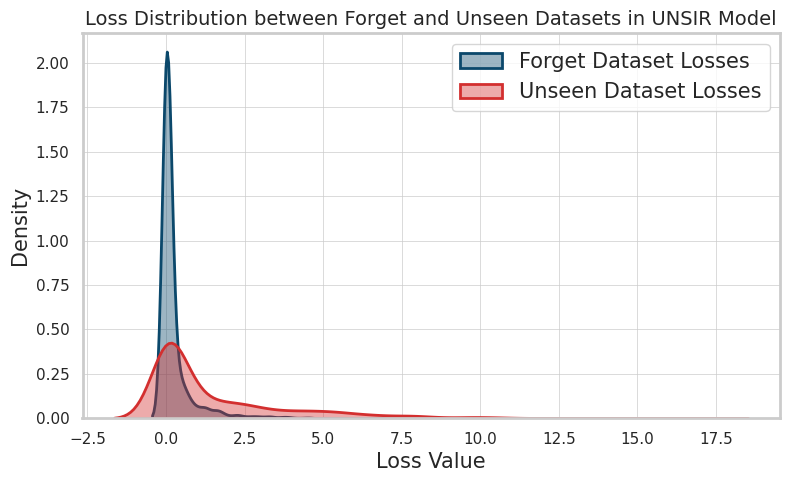

In [41]:
# visualize loss distribution
plot_kde_losses(unsir_forget_losses, unsir_unseen_losses, data1="Forget", data2="Unseen", model_name="UNSIR")

#### <b>Scrub</b>
* SCRUB employs a teacher-student formulation where the student model learns to selectively disobey the all-knowing teacher, minimizing divergence on retain data while maximizing it on forget data.
* Originally designed for class-level unlearning, SCRUB has been modified for instance-level forgetting in a task-agnostic context. In our adapted approach, we found that conducting the retain process first, followed by the forget process, yielded better performance for our tasks.

In [47]:
class DistillKL(nn.Module):
    def __init__(self, T):
        super(DistillKL, self).__init__()
        self.T = T

    def forward(self, y_s, y_t):
        p_s = F.log_softmax(y_s/self.T, dim=1)
        p_t = F.softmax(y_t/self.T, dim=1)
        loss = F.kl_div(p_s, p_t, size_average=False) * (self.T**2) / y_s.shape[0]
        return loss

In [50]:
original_save_path = 'pre_trained_last_checkpoint_epoch_30.pth'
teacher_model = load_model(8, original_save_path)
student_model = load_model(8, original_save_path)

criterion_cls = nn.CrossEntropyLoss()
criterion_div = DistillKL(4.0)
optimizer = optim.SGD(student_model.parameters(), lr=0.001)

num_epochs = 2
log_step = 20
for epoch in range(num_epochs):
    student_model.train()
    teacher_model.eval()

    total_loss_retain, total_accuracy_retain = 0, 0
    total_loss_forget, total_accuracy_forget = 0, 0

    for batch_idx, ((inputs_retain, labels_retain), (inputs_forget, labels_forget)) in enumerate(zip(retain_dataloader_train, forget_dataloader_train)):
        inputs_retain, labels_retain = inputs_retain.cuda(), labels_retain.cuda()
        inputs_forget, labels_forget = inputs_forget.cuda(), labels_forget.cuda()

        if inputs_retain.size(0) != inputs_forget.size(0):
            continue

        outputs_retain_student = student_model(inputs_retain)
        with torch.no_grad():
            outputs_retain_teacher = teacher_model(inputs_retain)
        loss_cls = criterion_cls(outputs_retain_student, labels_retain)
        loss_div_retain = criterion_div(outputs_retain_student, outputs_retain_teacher)
        loss_retain = loss_cls + loss_div_retain
        total_loss_retain += loss_retain.item()
        optimizer.zero_grad()
        loss_retain.backward()
        optimizer.step()

        outputs_forget_student = student_model(inputs_forget)
        with torch.no_grad():
            outputs_forget_teacher = teacher_model(inputs_forget)
        loss_div_forget = -criterion_div(outputs_forget_student, outputs_forget_teacher)
        total_loss_forget += loss_div_forget.item()
        optimizer.zero_grad()
        loss_div_forget.backward()
        optimizer.step()

        if batch_idx % log_step == 0:
            print(f'Epoch {epoch+1}, Batch {batch_idx+1}: Batch retain loss: {loss_retain.item():.4f}, Batch forget loss: {loss_div_forget.item():.4f}')

/home/bmi-admin/anaconda3/envs/unlearn/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 1, Batch 1: Batch retain loss: 0.2487, Batch forget loss: -0.9767
Epoch 1, Batch 21: Batch retain loss: 0.4501, Batch forget loss: -1.8136
Epoch 2, Batch 1: Batch retain loss: 0.8089, Batch forget loss: -0.9886
Epoch 2, Batch 21: Batch retain loss: 2.5082, Batch forget loss: -1.5333


In [54]:
test_acc = evaluation(student_model, test_dataloader)
unseen_acc = evaluation(student_model, unseen_dataloader)
mia = cal_mia(student_model.cuda())
final_score = (test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2
scrub_forget_losses = compute_losses(student_model, forget_dataloader_test)
scrub_unseen_losses = compute_losses(student_model, unseen_dataloader)
jsd = calculate_jsd_between_losses(scrub_forget_losses, scrub_unseen_losses)
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'JSD: {jsd}')
print()
print(f'Final Score: {final_score}')

[Test]
[Batch: 1] running test loss: 0.027206754311919212, running test accuracy: 0.65625, running top-2 accuracy: 0.90625
[Batch: 20] running test loss: 0.031481380295008424, running test accuracy: 0.58984375, running top-2 accuracy: 0.87109375
test loss: 0.0357602225099778, accuracy: 0.5854450942170241, top-2 accuracy: 0.8654970760233918
elapsed time: 1.3261959552764893
[Test]
[Batch: 1] running test loss: 0.02659364975988865, running test accuracy: 0.625, running top-2 accuracy: 0.921875
[Batch: 20] running test loss: 0.025220296857878566, running test accuracy: 0.6453125, running top-2 accuracy: 0.89609375
test loss: 0.02664663202743581, accuracy: 0.6416223404255319, top-2 accuracy: 0.8902925531914894
elapsed time: 1.245652437210083
Test Acc: {'Loss': 0.0357602225099778, 'Acc': 0.5854450942170241, 'Top-2 Acc': 0.8654970760233918}
Unseen Acc: {'Loss': 0.02664663202743581, 'Acc': 0.6416223404255319, 'Top-2 Acc': 0.8902925531914894}
MIA: {'MIA': 0.7139534883720932, 'Forgeting Score': 

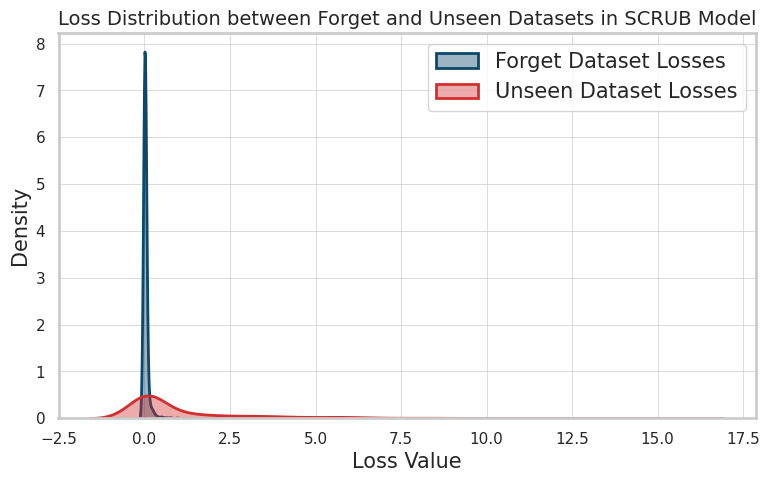

In [52]:
# visualize loss distribution
plot_kde_losses(scrub_forget_losses, scrub_unseen_losses, data1="Forget", data2="Unseen", model_name="SCRUB")

#### <b>Bad Teacher</b>
* The Bad Teaching Method uses a teacher-student model for targeted unlearning, where specific data is altered or removed to guide selective forgetting and knowledge retention.

In [53]:
class DistillKL(nn.Module):
    def __init__(self, T):
        super(DistillKL, self).__init__()
        self.T = T

    def forward(self, y_s, y_t):
        p_s = F.log_softmax(y_s/self.T, dim=1)
        p_t = F.softmax(y_t/self.T, dim=1)
        loss = F.kl_div(p_s, p_t, size_average=False) * (self.T**2) / y_s.shape[0]
        return loss

In [57]:
from itertools import cycle
set_seed()

original_save_path = 'pre_trained_last_checkpoint_epoch_30.pth'
good_teacher_model = load_model(8, original_save_path)
bad_teacher_model = load_model(8, None)
student_model = load_model(8, original_save_path)
criterion_cls = nn.CrossEntropyLoss()
criterion_div = DistillKL(4.0)
optimizer = optim.SGD(student_model.parameters(), lr=0.001)

student_model.train()
good_teacher_model.eval()
bad_teacher_model.eval()

total_loss, total_accuracy = 0, 0

num_epoch = 2
log_step = 20
delete_iterator = cycle(forget_dataloader_train)

for epoch in range(num_epoch):
    
    for batch_idx, (inputs, labels) in enumerate(retain_dataloader_train):
        inputs, labels = inputs.cuda(), labels.cuda()
        inputs_del, labels_del = next(delete_iterator)
        inputs_del, labels_del = inputs_del.cuda(), labels_del.cuda()

        optimizer.zero_grad()
        logits_s = student_model(inputs)
        logits_s_del = student_model(inputs_del)

        with torch.no_grad():
            logits_gt = good_teacher_model(inputs)
            logits_bt_del = bad_teacher_model(inputs_del)

        loss_cls = criterion_cls(logits_s, labels)
        loss_div = criterion_div(logits_s, logits_gt)
        loss_div_del = criterion_div(logits_s_del, logits_bt_del)

        loss = 1 * loss_div + 1 * loss_div_del
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_accuracy += (logits_s.max(1)[1] == labels).float().mean().item()

        if batch_idx % log_step == 0:
            print(f'Batch {batch_idx}: Train Loss: {total_loss / (batch_idx+1):.4f}, Train Accuracy: {total_accuracy / (batch_idx+1):.2f}%')

Batch 0: Train Loss: 24.1406, Train Accuracy: 1.00%
Batch 20: Train Loss: 14.6585, Train Accuracy: 0.95%
Batch 40: Train Loss: 12.1147, Train Accuracy: 0.95%
Batch 60: Train Loss: 10.9826, Train Accuracy: 0.95%
Batch 80: Train Loss: 10.3420, Train Accuracy: 0.95%
Batch 100: Train Loss: 9.8451, Train Accuracy: 0.95%
Batch 120: Train Loss: 9.4557, Train Accuracy: 0.95%
Batch 0: Train Loss: 1245.8726, Train Accuracy: 128.22%
Batch 20: Train Loss: 65.8563, Train Accuracy: 7.01%
Batch 40: Train Loss: 36.9234, Train Accuracy: 4.04%
Batch 60: Train Loss: 26.8157, Train Accuracy: 3.02%
Batch 80: Train Loss: 21.5917, Train Accuracy: 2.51%
Batch 100: Train Loss: 18.3068, Train Accuracy: 2.20%
Batch 120: Train Loss: 16.1068, Train Accuracy: 1.99%


In [58]:
test_acc = evaluation(student_model, test_dataloader)
unseen_acc = evaluation(student_model, unseen_dataloader)
mia = cal_mia(student_model.cuda())
final_score = (test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2
bad_teacher_forget_losses = compute_losses(student_model, forget_dataloader_test)
bad_teacher_unseen_losses = compute_losses(student_model, unseen_dataloader)
jsd = calculate_jsd_between_losses(bad_teacher_forget_losses, bad_teacher_unseen_losses)
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'JSD: {jsd}')
print()
print(f'Final Score: {final_score}')

[Test]
[Batch: 1] running test loss: 0.02803824283182621, running test accuracy: 0.578125, running top-2 accuracy: 0.765625
[Batch: 20] running test loss: 0.023023004131391644, running test accuracy: 0.5359375, running top-2 accuracy: 0.8078125
test loss: 0.024980909217093346, accuracy: 0.5354126055880442, top-2 accuracy: 0.8005198180636777
elapsed time: 1.4009530544281006
[Test]
[Batch: 1] running test loss: 0.01624622382223606, running test accuracy: 0.625, running top-2 accuracy: 0.890625
[Batch: 20] running test loss: 0.019215637305751442, running test accuracy: 0.60078125, running top-2 accuracy: 0.84375
test loss: 0.020112616465763844, accuracy: 0.6070478723404256, top-2 accuracy: 0.8410904255319149
elapsed time: 1.2838051319122314
Test Acc: {'Loss': 0.024980909217093346, 'Acc': 0.5354126055880442, 'Top-2 Acc': 0.8005198180636777}
Unseen Acc: {'Loss': 0.020112616465763844, 'Acc': 0.6070478723404256, 'Top-2 Acc': 0.8410904255319149}
MIA: {'MIA': 0.6475083056478406, 'Forgeting Scor

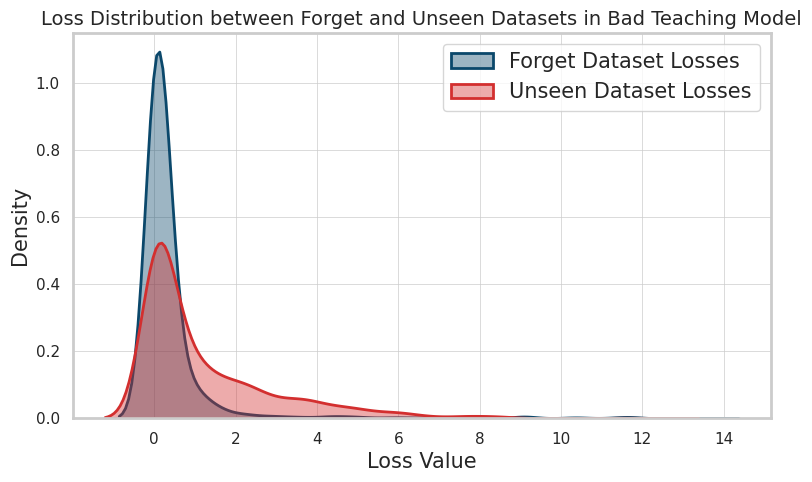

In [59]:
# visualize loss distribution
plot_kde_losses(bad_teacher_forget_losses, bad_teacher_unseen_losses, data1="Forget", data2="Unseen", model_name="Bad Teaching")

#### <b>EU-K</b>
* The EU-K Method retrains the last k layers of a model with the remaining data, excluding targeted data for forgetting, while keeping the initial layers unchanged, aiming for precise unlearning of specific information.

In [63]:
set_seed()

original_model_path = 'pre_trained_last_checkpoint_epoch_30.pth'
original_model = load_model(8, original_model_path)
euk_model = load_model(8, original_model_path)

# Disable gradients for all parameters in euk_model
for param in euk_model.parameters():
    param.requires_grad = False

# Restore the weights for specific layers and enable their gradients in euk_model
with torch.no_grad():
    initial_params = dict(original_model.named_parameters())
    euk_params = dict(euk_model.named_parameters())

    layers_to_unlearn = ['layer3.' + str(i) for i in range(2)]  

    for layer_name in layers_to_unlearn:
        # Extract layer-specific parameters based on the prefix
        layer_params = {k: v for k, v in initial_params.items() if k.startswith(layer_name)}
        for param_name, param in layer_params.items():
            # Replace the corresponding parameter in euk_model
            euk_params[param_name].data.copy_(param.data)
            # Enable the gradient for this parameter
            euk_params[param_name].requires_grad = True

# Fine-tune only the layers with enabled gradients in euk_model
optimizer = optim.SGD(filter(lambda p: p.requires_grad, euk_model.parameters()), lr=0.01)
criterion = nn.CrossEntropyLoss()

euk_model.train()
top1_acc_list, forgetting_score_list, final_score_list = [], [], []
log_step = 20
for epoch in range(2):
    for batch_idx, (inputs, labels) in enumerate(retain_dataloader_train):
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = euk_model(inputs)
        if labels.size(0) != outputs.size(0):
            continue
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_step == 0:
            print(f'Batch {batch_idx}: Train Loss: {total_loss / (batch_idx + 1):.4f}, - Batch Loss: {loss.item():.4f}')

Batch 0: Train Loss: 2000.6927, - Batch Loss: 0.0681
Batch 20: Train Loss: 95.2711, - Batch Loss: 0.1107
Batch 40: Train Loss: 48.7974, - Batch Loss: 0.0792
Batch 60: Train Loss: 32.7982, - Batch Loss: 0.1701
Batch 80: Train Loss: 24.6999, - Batch Loss: 0.1864
Batch 100: Train Loss: 19.8088, - Batch Loss: 0.0629
Batch 120: Train Loss: 16.5347, - Batch Loss: 0.1274
Batch 0: Train Loss: 2000.6927, - Batch Loss: 0.0296
Batch 20: Train Loss: 95.2711, - Batch Loss: 0.0458
Batch 40: Train Loss: 48.7974, - Batch Loss: 0.0417
Batch 60: Train Loss: 32.7982, - Batch Loss: 0.1684
Batch 80: Train Loss: 24.6999, - Batch Loss: 0.1811
Batch 100: Train Loss: 19.8088, - Batch Loss: 0.1324
Batch 120: Train Loss: 16.5347, - Batch Loss: 0.2145


In [64]:
test_acc = evaluation(euk_model, test_dataloader)
unseen_acc = evaluation(euk_model, unseen_dataloader)
mia = cal_mia(euk_model.cuda())
final_score = (test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2
euk_forget_losses = compute_losses(euk_model, forget_dataloader_test)
euk_unseen_losses = compute_losses(euk_model, unseen_dataloader)
jsd = calculate_jsd_between_losses(euk_forget_losses, euk_unseen_losses)
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'JSD: {jsd}')
print()
print(f'Final Score: {final_score}')

[Test]
[Batch: 1] running test loss: 0.023428751155734062, running test accuracy: 0.671875, running top-2 accuracy: 0.9375
[Batch: 20] running test loss: 0.025202330946922303, running test accuracy: 0.5921875, running top-2 accuracy: 0.8859375
test loss: 0.027345558201205506, accuracy: 0.5873944119558154, top-2 accuracy: 0.8830409356725146
elapsed time: 1.237177848815918
[Test]
[Batch: 1] running test loss: 0.019310399889945984, running test accuracy: 0.6875, running top-2 accuracy: 0.953125
[Batch: 20] running test loss: 0.020683543244376778, running test accuracy: 0.65859375, running top-2 accuracy: 0.89765625
test loss: 0.02175504654804443, accuracy: 0.6582446808510638, top-2 accuracy: 0.8962765957446809
elapsed time: 1.2256255149841309
Test Acc: {'Loss': 0.027345558201205506, 'Acc': 0.5873944119558154, 'Top-2 Acc': 0.8830409356725146}
Unseen Acc: {'Loss': 0.02175504654804443, 'Acc': 0.6582446808510638, 'Top-2 Acc': 0.8962765957446809}
MIA: {'MIA': 0.707641196013289, 'Forgeting Scor

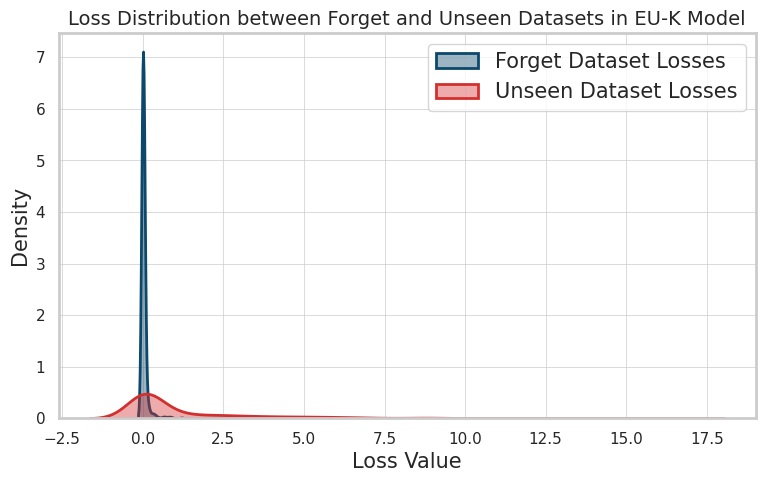

In [65]:
# visualize loss distribution
plot_kde_losses(euk_forget_losses, euk_unseen_losses, data1="Forget", data2="Unseen", model_name="EU-K")